# Desafío LATAM
Autor: Juan d'Etigny $\\\\$
### Contenidos
- [Primera vista a los datos](#Primera-vista-a-los-datos)
- [Variables adicionales](#Variables-adicionales)
- [Segunda vista a los datos](#Segunda-vista-a-los-datos)
- [Modelos de predicción y variables externas](#Modelos-de-predicción-y-variables-externas)
- [Evaluación y posibles mejoras](#Evaluación-y-posibles-mejoras)

# Primera vista a los datos

En la siguiente sección cargaremos los datos que se nos entregan, haremos una primera limpieza de estos, y haremos un análisis de cómo se ve la información antes de darle un uso de predicción

In [1]:
#Before doing any work we first group all the imports used in this work
import pandas as pd
import numpy as np
import sklearn as sk
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, spearmanr
from sklearn.model_selection import cross_val_score

Cargamos los datos del dataset y los fijamos en un dataframe de pandas. Acá notamos que las variables de fechas se deben específicar para utilizar los métodos nativos que la librería tiene para operar este tipo de información.

A continuación visualizamos las información principial del dataframe:$\\\\$

In [2]:
df = pd.read_csv('dataset_SCL.csv',parse_dates=['Fecha-I','Fecha-O'])
df.head()

/Users/juanito/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [3]:
df.columns = df.columns.str.strip()
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

In [4]:
print('---------------------------\nInformación general:\n---------------------------')
df.info()
print('\n---------------------------\nValores únicos por columna:\n---------------------------\n',df.nunique())


---------------------------
Información general:
---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  AÑO        68206 non-null  int64         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA     

A primera instancia hay ciertas cosas que vemos: Primero notamos que el volumen de datos es medio-alto con ($\sim 70000$), y que tenemos 18 features (no todas van a ser útiles para el modelo final).

Vemos también que hay discrepancias con respecto a la cantidad de valores únicos entre las variables programadas y las correspondentes variables en operación. Algunas de estas variables quizás posean causalidad con respecto a un atraso, algunas puede que sean artificiales (distintas convenciones de nombres entre programación y operación por ejemplo), pero otras quizás son resultado de dicho atraso. Es difícil validar una razón para cada una sin tener información adicional del problema.

Notamos también que para el problema, solo tenemos una ciudad de origen (Santiago). Esto tiene sentido por el contexto de nuestro problema, pero va a significar que el modelo va a tener indudablemente un bias, y no debería usarse para otras ciudades de origen.

$\\\\$ Procedemos ahora chequeamos y arreglamos potenciales NaNs o filas duplicadas: $\\\\$

In [5]:
print('---------------------------\nInformación np.nan:\n---------------------------\n',df.isna().sum())

print('---------------------------\nInformación duplicada:\n---------------------------\n',np.where(df.duplicated()==True)[0])

---------------------------
Información np.nan:
---------------------------
 Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64
---------------------------
Información duplicada:
---------------------------
 []


In [6]:
df['Vlo-O'][np.where(df['Vlo-O'].isna())[0]] = df['Vlo-I'][np.where(df['Vlo-O'].isna())[0]]
df["Vlo-O"] = df["Vlo-O"].astype(str)
df["Vlo-I"] = df["Vlo-I"].astype(str)

/Users/juanito/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Notamos que no hay información duplicada y que solo había una entrada inválida en el conjunto de datos. Ahora continuamos viendo la distribución de los parámetros, hacemos estas visualizaciones en la forma de histogramas. 

Notamos ahora, que si aislamos la muestra por año de salida en cada vuelo, se observa que la cantidad de entradas tabuladas en 2018 es extremadamente baja, por lo que considerar dichos vuelos puede en el mejor de los casos mejorar un baja medida el modelo, y en el peor de los casos introducir bias. 

In [7]:
print('Rango de fechas: ',min(df['Fecha-O']),max(df['Fecha-O']))
print('Vuelos tabulados en 2018', np.size(df[df['AÑO']=='2018']))

Rango de fechas:  2017-01-01 00:04:00 2018-01-01 00:12:00
Vuelos tabulados en 2018 0


Vemos ahora primero la distribución de vuelos tabulados en nuestros datos, con respecto a la fecha de salida (fecha completa, mes, día):

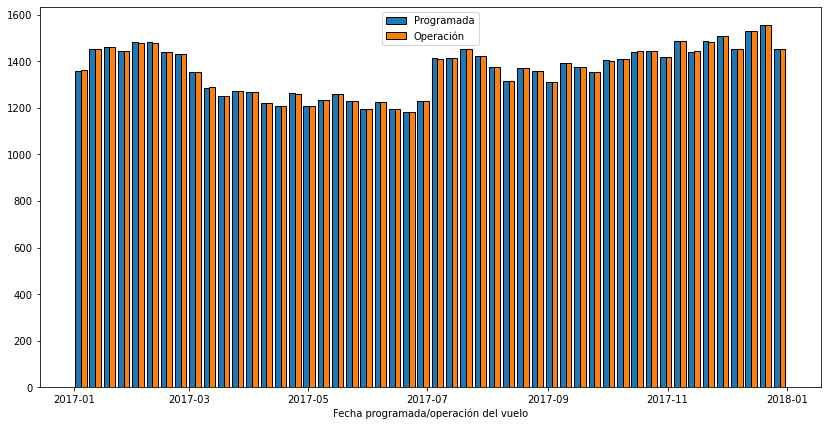

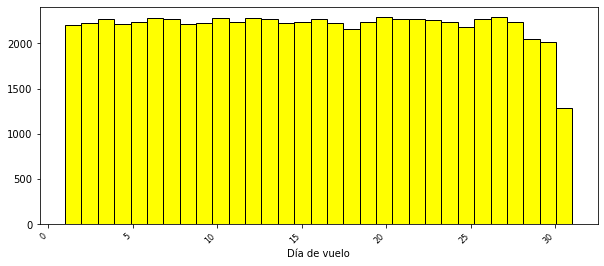

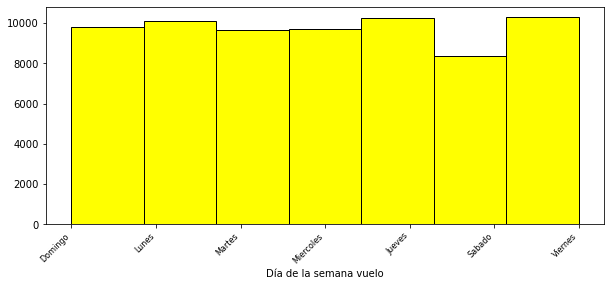

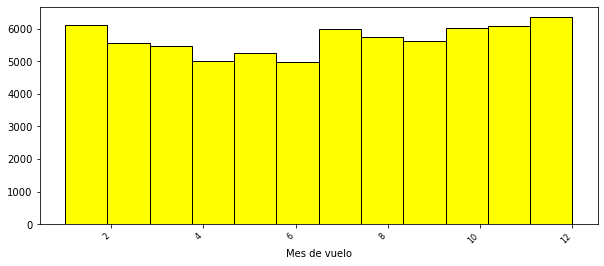

In [8]:
plt.figure(1,figsize=(14,7))
plt.hist([df['Fecha-I'],df['Fecha-O']],50,edgecolor='black')#,color='yellow')
plt.xlabel('Fecha programada/operación del vuelo')
plt.legend(['Programada','Operación'])
plt.show()

plt.figure(2,figsize=(10,4))
plt.hist(df['DIA'],31,edgecolor='black',color='yellow')
plt.xlabel('Día de vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(3,figsize=(10,4))
plt.hist(df['DIANOM'],7,edgecolor='black',color='yellow')
plt.xlabel('Día de la semana vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(4,figsize=(10,4))
plt.hist(df['MES'],12,edgecolor='black',color='yellow')
plt.xlabel('Mes de vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()


Vemos que la información no muestra ninguna información demasiado relevante fuera de como la frecuencia de vuelos aumenta para las temporadas altas de Santiago, dígase, vacaciones de verano, de invierno y en menor medida vacaciones de septiembre.

Veamos ahora como distribuyen el código de vuelo y de aerolínea:$\\\\$

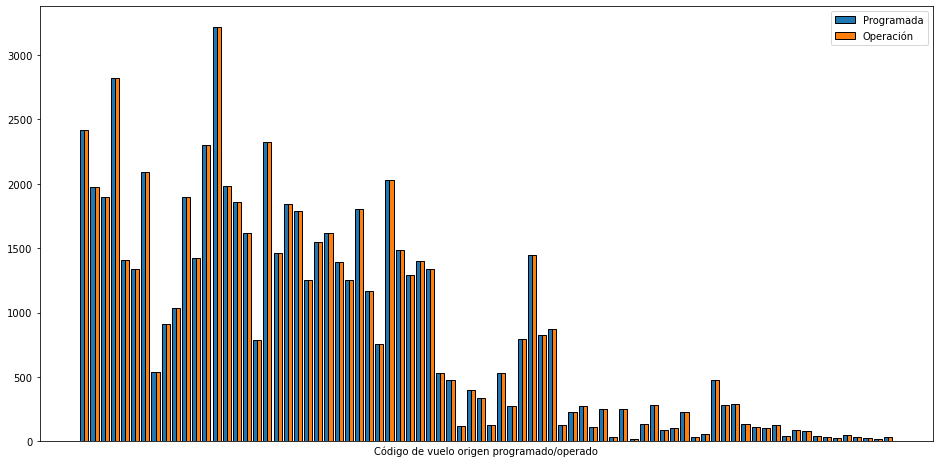

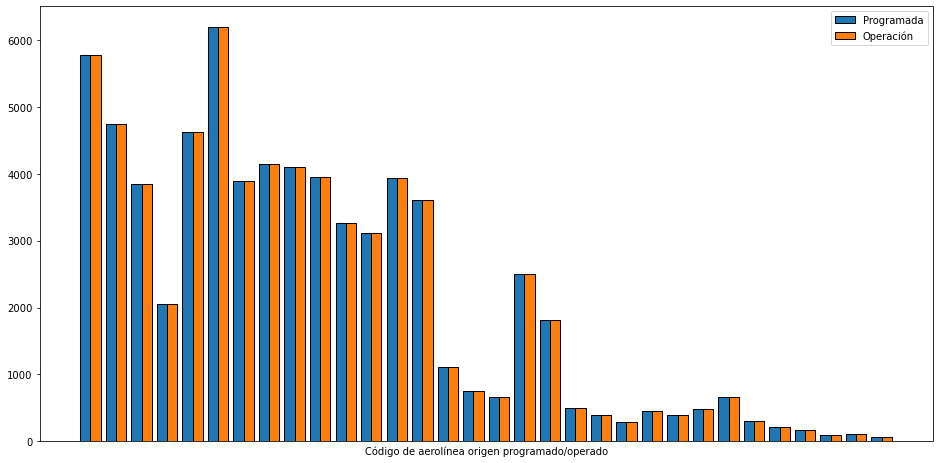

[]

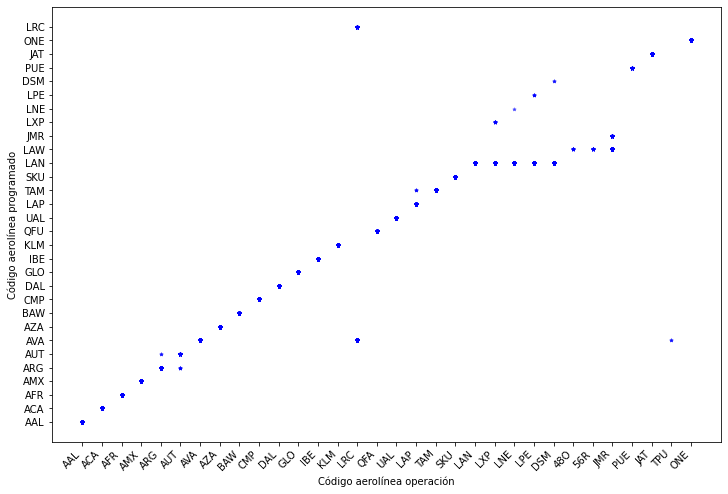

In [9]:
plt.figure(1,figsize=(16,8))
plt.hist([df['Vlo-I'],df['Vlo-I']],80,edgecolor='black')
plt.xlabel('Código de vuelo origen programado/operado')
plt.legend(['Programada','Operación'])
plt.xticks([])
plt.show()

plt.figure(2,figsize=(16,8))
plt.hist([df['Vlo-I'],df['Vlo-I']],32,edgecolor='black')
plt.xlabel('Código de aerolínea origen programado/operado')
plt.legend(['Programada','Operación'])
plt.xticks([])
plt.show()

plt.figure(4,figsize=(12,8))
plt.xlabel(r'Código aerolínea operación')
plt.ylabel(r'Código aerolínea programado')
plt.scatter(df["Emp-O"],df['Emp-I'],marker='*',alpha=0.5,s=10,c='blue')
plt.xticks(rotation=45, ha="right")
plt.plot()

La distribución de estos datos, muestra en los histogramas que la distribución de los códigos de vuelo es relativamente similar a la distribución de aerolíneas. Esto no es sorpresivo dado a que los códigos de vuelo por convención, finalmente van a ser una indexación de aerolínea+destino.

Mencionamos también como en los datos había una discrepancia entre la cantidad de valores únicos de los códigos programados y los de operación. Sin información previa podríamos creer quizás que esto indica algún problema de itinerario o complicación que entrega información útil para predecir atrasos, pero este no es el caso. Viendo la figura que plotea el código de aerolínea programada vs operación notamos por ejemplo que la mayoría de los conflictos ocurren con la nomenclatura de los vuelos programados de LAN, pero al mismo tiempo vemos que los códigos correspondientes de operación son variantes que dependen de la misma aerolínea (eg: LXP es Latam Express y LNE es Latam Ecuador), y esto nos dice que simplemente cambia el criterio de nomenclatura entre las dos listas, por lo que no debiese ser una propiedad ligada a los atrasos. Esta misma línea explica la diferencia entre los códigos de vuelo.

Veamos ahora la distribución de destinos: $\\\\$

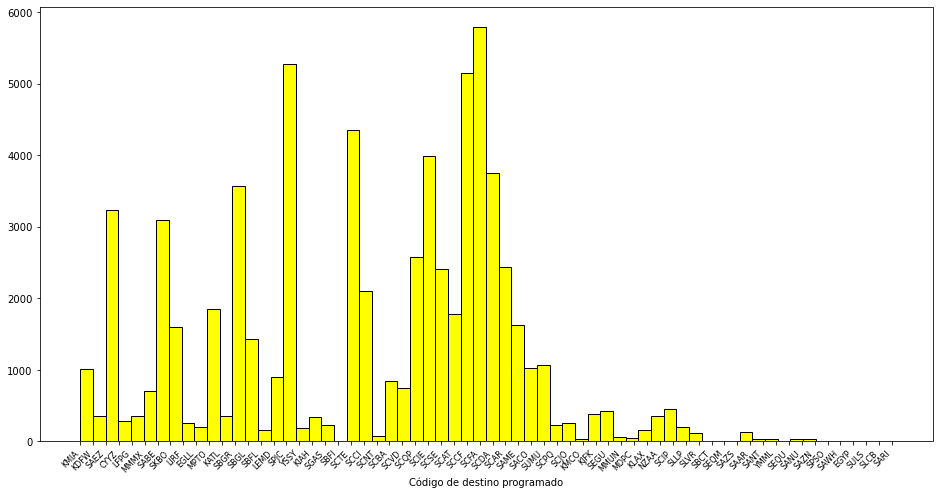

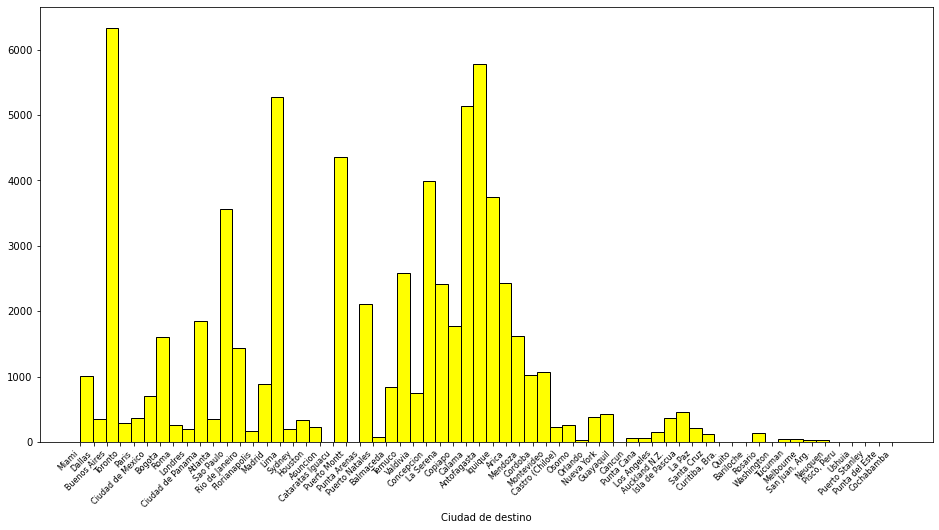

In [10]:
plt.figure(1,figsize=(16,8))
plt.hist(df['Des-I'],64,edgecolor='black',color='yellow')
plt.xlabel('Código de destino programado')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

plt.figure(2,figsize=(16,8))
plt.hist(df['SIGLADES'],64,edgecolor='black',color='yellow')
plt.xlabel('Ciudad de destino')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()


Nuevamente esta distribución de por sí no dice demasiado con respecto al problema, fuera de que así como en el caso de las variables anteriores, hay una pequeña discrepancia entre el código de destino y la ciudad de destino. Esto no es difícil de explicar, pues hay ciudades que tienen diferentes códigos de destino, debido a que el aeropuerto va a afectar dicho código. Por ejemplo la cantidad de datos en Buenos Aires no aparece directamente en los códigos de llegada, ya que el destino posee dos aeropuertos: Ezeiza y Aeroparque.

En el caso anterior y este caso, esta pseudo redundancia de datos, no es extremadamente grave: En el peor de los casos la eficiencia del algoritmo al entrenar, va a ser más lenta. En el mejor de los casos la separación de los datos da una pequeña cantidad de información adicional y mejora el modelo. 

Finalmente veamos como se separan los datos por aerolínea: $\\\\$

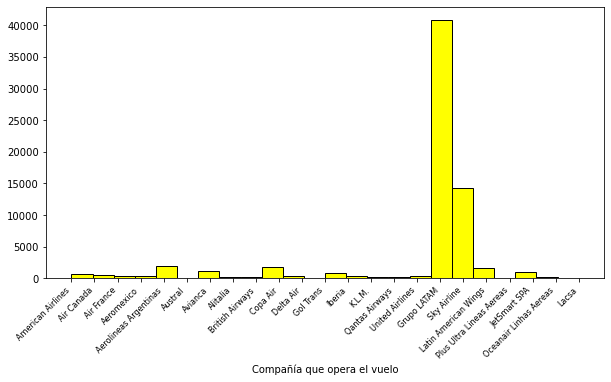

In [11]:
plt.figure(1,figsize=(10,5))
plt.hist(df['OPERA'],24,edgecolor='black',color='yellow')
plt.xlabel('Compañía que opera el vuelo')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.show()

De acá vemos que la mayoría de los vuelos se concentran en las dos aerolíneas Chilenas más grandes, que es un ejemplo de los sesgos que introduce el hecho de que la ciudad de origen de nuestro análisis sea siempre Santiago. Esto puede ser relevante por ejemplo porque existe el riesgo de mal-representar el comportamiento de aerolíneas subrepresentadas en la muestra.

Normalmente uno puede cuantificar la redundancia de ciertos features en nuestros datos, pero para hacer esto uno necesita poder generar por ejemplo una matriz (gráfico) de correlaciones entre dichos features, lo que no es de inmediato evidente para features que tienen tipos de datos mixtos. Esto es posible de hacer (simple, incluso) pero típicamente requiere la instalación de alguna librería adicional que las que tenemos en uso. 

Procedemos ahora a generar variables adicionales que cuantifican los atrasos y otros datos:$\\\\$


# Variables adicionales

A continuación generamos features adicionales desde los datos que ya tenemos disponibles. Específicamente generamos los siguientes datos:
- Variable binaria que indica si el vuelo ocurre en temporada alta
- Diferencia en minutos entre salida programada y en operación
- Variable binaria que indica si el atraso de un vuelo es mayor a 15minutos
- El periodo horario de la salida de cada vuelo, dentro de su día 


In [12]:
col = df['Fecha-O']
print(min(col),max(col))

dif_min = (df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60
dif_min = np.round(dif_min,3)

I1 = np.where((col > '2017-12-15'))[0]
I2 = np.where((col > '2017-9-11') & (col < '2017-9-30'))[0]
I3 = np.where((col > '2017-7-15') & (col < '2017-7-31'))[0]
I4 = np.where((col > '2017-1-1') & (col < '2017-3-3'))[0]
temporada_alta = np.zeros(np.shape(col))
temporada_alta[I1] = 1
temporada_alta[I2] = 1
temporada_alta[I3] = 1
temporada_alta[I4] = 1

atraso_15 = np.zeros(np.shape(col))
atraso_15[dif_min>15] = 1

periodo_dia = np.zeros(np.shape(col),dtype=object)
I1 = np.where((col.dt.hour >= 5) & (col.dt.hour < 12))[0]
I2 = np.where((col.dt.hour >= 12) & (col.dt.hour < 19))[0]
I3 = np.where((col.dt.hour >= 19) | (col.dt.hour < 5))[0]
periodo_dia[I1] = 'mañana'
periodo_dia[I2] = 'tarde'
periodo_dia[I3] = 'noche'

2017-01-01 00:04:00 2018-01-01 00:12:00


In [13]:
synth = pd.DataFrame({'dif_min' : dif_min, 'atraso_15' : atraso_15, 'temporada_alta' : temporada_alta,
                      'periodo_dia':periodo_dia})
synth.to_csv(r'synthetic_features.csv',index=False)

In [14]:
df_synth = pd.read_csv('synthetic_features.csv')
df2 = pd.concat([df,df_synth],axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha-I         68206 non-null  datetime64[ns]
 1   Vlo-I           68206 non-null  object        
 2   Ori-I           68206 non-null  object        
 3   Des-I           68206 non-null  object        
 4   Emp-I           68206 non-null  object        
 5   Fecha-O         68206 non-null  datetime64[ns]
 6   Vlo-O           68206 non-null  object        
 7   Ori-O           68206 non-null  object        
 8   Des-O           68206 non-null  object        
 9   Emp-O           68206 non-null  object        
 10  DIA             68206 non-null  int64         
 11  MES             68206 non-null  int64         
 12  AÑO             68206 non-null  int64         
 13  DIANOM          68206 non-null  object        
 14  TIPOVUELO       68206 non-null  object        
 15  OP

# Segunda vista a los datos

Le damos ahora una segunda vista a los datos antes de efectivamente generar los modelos. Específicamente vamos a ver como distribuyen algunos de nuestros features en relación a nuestra nueva variable a modelar, que es la tasa de atrasos mayores a 15 minutos.

Comenzamos viendo como se ve la distribución de atrasos puesta en los datos de las ciudades de destino:$\\\\$


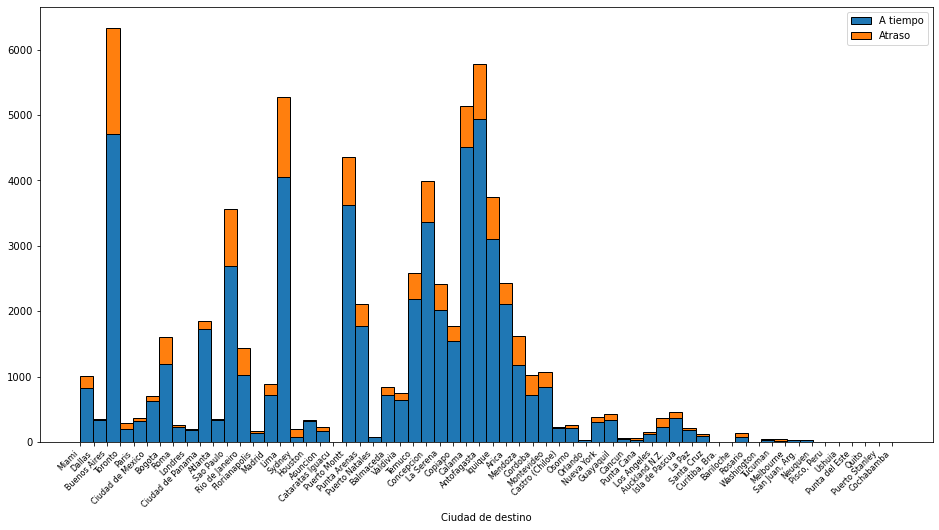

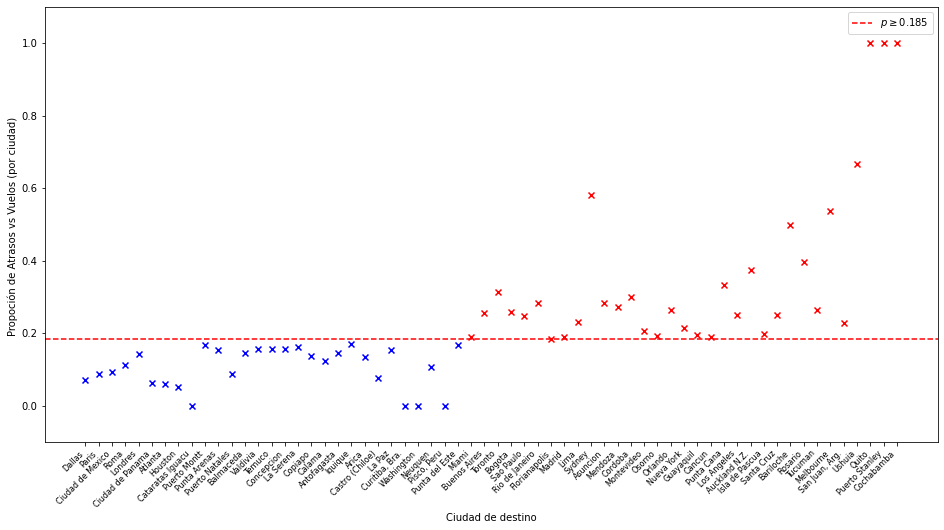

In [15]:
plt.figure(1,figsize=(16,8))
(n, bins, p) = plt.hist([df2['SIGLADES'][df2['atraso_15']==0],df2['SIGLADES'][df2['atraso_15']==1]],
                        62,edgecolor='black',stacked=True)
plt.xlabel('Ciudad de destino')
num, X = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

x = []
for s in X:
    x.append(s.get_text())
x = np.array(x)
prop = (n[1]-n[0])/n[1]

av_at = np.size(np.where(df2['atraso_15']>0)[0])/np.size(df2['atraso_15'])

plt.figure(2,figsize=(16,8))
plt.scatter(x[prop<=av_at],prop[prop<=av_at],marker='x',color='blue')
plt.scatter(x[prop>av_at],prop[prop>av_at],marker='x',color='red')
plt.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.ylim((0-0.1,1+0.1))
plt.xlabel('Ciudad de destino')
plt.ylabel('Propoción de Atrasos vs Vuelos (por ciudad) ')
plt.legend()
plt.show()

Arriba visualizamos un histograma donde se stackean las instancias de atraso sobre las a tiempo, junto a un gráfico de dispersión que da la proporción de vuelos a tiempo vs atraso, tabulada en función de las etiquetas del feature correspondiente. 

En el segundo plot ponemos una línea de que dibuja la interfaz de la proporción de atrasos totales v/s a tiempo para entender a escala interna, cual es una proporción de atrasos 'alta' y cual es una proporción de atrasos 'baja'.

En el caso anterior vemos que la variable es informativa en la medida que si bien muchos de los destinos están cerca de la línea promedio, y por ende son destinos que no nos van a dar un alto valor predictivo para saber si es que un atraso es más o menos probable, sí existe una porción de destinos que se apegan más a los extremos (tanto positivos como negativos) de atraso, en donde este parámetro nos va a dar una buena cantidad de información.

Veamos ahora lo mismo por aerolínea: $\\\\$


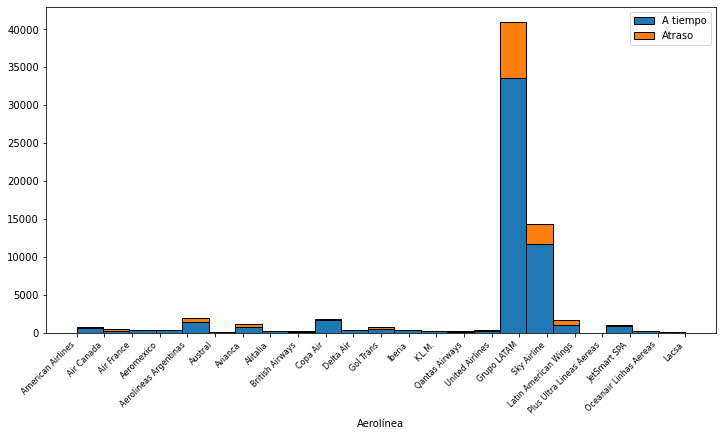

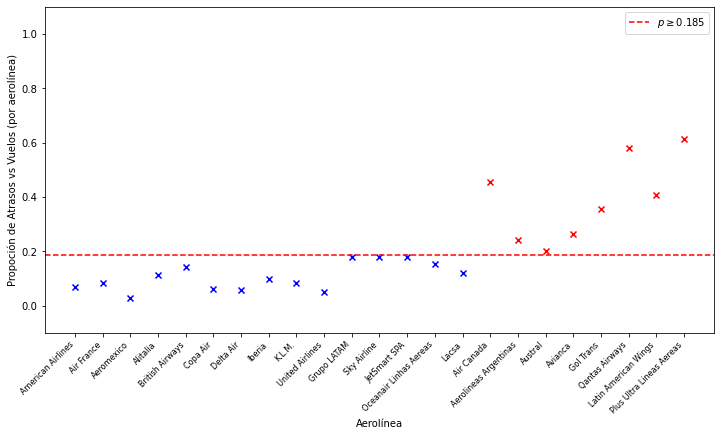

In [16]:
plt.figure(1,figsize=(12,6))
(n, bins, p) = plt.hist([df2['OPERA'][df2['atraso_15']==0],df2['OPERA'][df2['atraso_15']==1]],
                        23,edgecolor='black',stacked=True)
plt.xlabel('Aerolínea')
num, X = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

x = []
for s in X:
    x.append(s.get_text())
x = np.array(x)
prop = (n[1]-n[0])/n[1] 

plt.figure(2,figsize=(12,6))
plt.scatter(x[prop<=av_at],prop[prop<=av_at],marker='x',color='blue')
plt.scatter(x[prop>av_at],prop[prop>av_at],marker='x',color='red')
plt.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.ylim((0-0.1,1+0.1))
plt.legend()
plt.xlabel('Aerolínea')
plt.ylabel('Propoción de Atrasos vs Vuelos (por aerolínea)')
plt.show()

Acá vemos una variedad de valores en términos de la proporción de atrasos, pero nuevamente referimos a lo que se mencionó en el análisis original de los datos de vuelos por aerolínea, dígase el hecho de que por la gran diferencia en escala de salidas por aerolínea, la visualización de la información a veces es engañosa. 

Por ejemplo, el valor real de la información de la proporción de atrasos de Qantas es menos valioso que el de Avianca, por el volumen de vuelos totales que salen de santiago para las respectivas aerolíneas.

Veamos ahora la información por mes y día, y para las variables binarias de vuelos nacionales/internacionales y de temporada en el año. $\\\\$

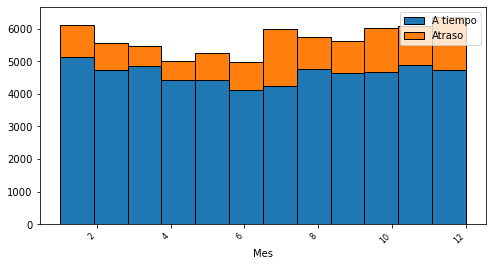

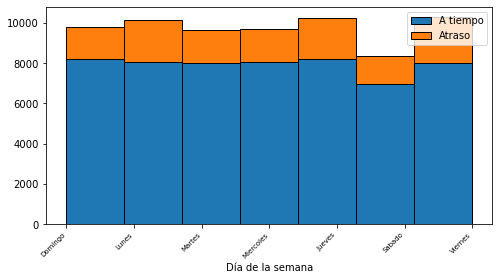

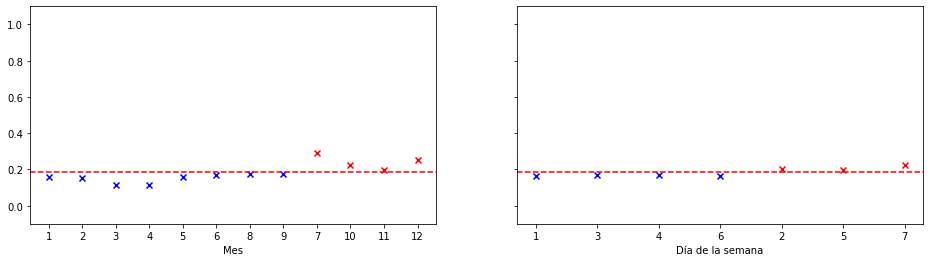

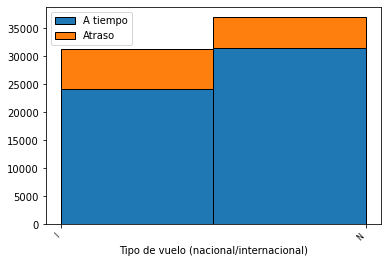

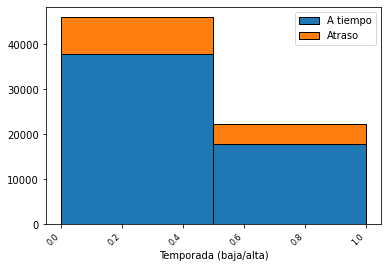

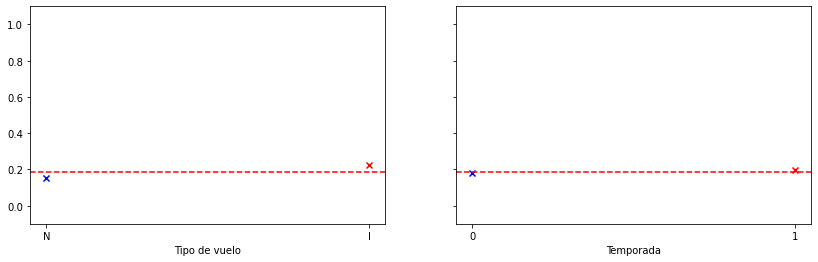

In [17]:
plt.figure(1,figsize=(8,4))
(n1, bins, p) = plt.hist([df2['MES'][df2['atraso_15']==0],df2['MES'][df2['atraso_15']==1]],
                        bins=12,edgecolor='black',stacked=True)
plt.xlabel('Mes')
num1, X1 = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()


plt.figure(2,figsize=(8,4))
(n2, bins, p) = plt.hist([df2['DIANOM'][df2['atraso_15']==0],df2['DIANOM'][df2['atraso_15']==1]],
                        7,edgecolor='black',stacked=True)
plt.xlabel('Día de la semana')
num2, X2 = plt.xticks(rotation=45, ha="right",fontsize=7)
plt.legend(['A tiempo','Atraso'])
plt.show()

x1 = np.array(['1','2','3','4','5','6','7','8','9','10','11','12'])
prop1 = (n1[1]-n1[0])/n1[1]
x2 = np.array(['1','2','3','4','5','6','7'])
prop2 = (n2[1]-n2[0])/n2[1] 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4),sharey=True)
ax1.scatter(x1[prop1<=av_at],prop1[prop1<=av_at],marker='x',color='blue')
ax1.scatter(x1[prop1>av_at],prop1[prop1>av_at],marker='x',color='red')
ax1.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
ax1.set_ylim([0-0.1, 1+0.1])
ax1.set_xlabel('Mes')

ax2.scatter(x2[prop2<=av_at],prop2[prop2<=av_at],marker='x',color='blue')
ax2.scatter(x2[prop2>av_at],prop2[prop2>av_at],marker='x',color='red')
ax2.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
ax2.set_xlabel('Día de la semana')

plt.show()

####----------------------------------------------------------------------------------------------------------------
####----------------------------------------------------------------------------------------------------------------

plt.figure(3)
(n3, bins, p) = plt.hist([df2['TIPOVUELO'][df2['atraso_15']==0],df2['TIPOVUELO'][df2['atraso_15']==1]],
                        2,edgecolor='black',stacked=True)
plt.xlabel('Tipo de vuelo (nacional/internacional)')
num3, X3 = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

plt.figure(4)
(n4, bins, p) = plt.hist([df2['temporada_alta'][df2['atraso_15']==0],df2['temporada_alta'][df2['atraso_15']==1]],
                        2,edgecolor='black',stacked=True)
plt.xlabel('Temporada (baja/alta)')
num4, X4 = plt.xticks(rotation=45, ha="right",fontsize=8)
plt.legend(['A tiempo','Atraso'])
plt.show()

x3 = []
for s in X3:
    x3.append(s.get_text())
x3 = np.array(x3)
prop3 = (n3[1]-n3[0])/n3[1]

x4 = []
for s in X4:
    x4.append(s.get_text())
x4 = np.array(x4)
prop4 = (n4[1]-n4[0])/n4[1] 

x4 = np.array(['0','1'])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,4))
ax1.scatter(x3[prop3<=av_at],prop3[prop3<=av_at],marker='x',color='blue')
ax1.scatter(x3[prop3>av_at],prop3[prop3>av_at],marker='x',color='red')
ax1.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
ax1.set_ylim([0-0.1, 1+0.1])
ax1.set_xlabel('Tipo de vuelo')

ax2.scatter(x4[prop4<=av_at],prop4[prop4<=av_at],marker='x',color='blue')
ax2.scatter(x4[prop4>av_at],prop4[prop4>av_at],marker='x',color='red')
ax2.axhline(y = av_at, color='red', linestyle='--',label=f'$p\geq {np.round(av_at,3)}$')
ax2.set_xlabel('Temporada')

plt.show()

Notamos que esta información a priori pareciera ser menos informativa, en donde la proporción de atrasos parece tener poca dependencia tanto con respecto a los días de la semana y los meses. 

Con respecto a las variables binarias, las variables parecieran tener un bajo valor explicativo. Al mismo tiempo la información de estos gráficos puede no ser demasiado informativa, para lo que podemos ver quizás la correlación entre estos features y la tasa de atrasos:
$\\\\$

In [18]:
param=[]
correlation=[]
abs_corr=[]

for c in ['TIPOVUELO','temporada_alta']:
    #Check if binary or continuous
    corr = spearmanr(df2['atraso_15'],df2[c])[0]
    param.append(c)
    correlation.append(corr)
    abs_corr.append(abs(corr))

param_df=pd.DataFrame({'correlation':correlation,'parameter':param, 'abs_corr':abs_corr})
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)
param_df=param_df.set_index('parameter')

param_df

,correlation,abs_corr
parameter,,
TIPOVUELO,-0.096295,0.096295
temporada_alta,0.020332,0.020332


El valor absoluto de estas correlaciones efectivamente confirma que el valor explicativo de estas variables es bajo (la correlación para el Spearman rank está hecha sobre -1 y 1).

# Modelos de predicción y variables externas

$\\\\$ Procedemos ahora a generar nuestros modelos supervisados para la predicción de atrasos. El primer paso va a ser eliminar algunas de las variables que ya mencionamos, no necesitaremos. Además hacemos la primera separación entre variables numéricas y variables categóricas. $\\\\$


In [19]:
fields = list(df2.columns)

#List of features used for the model training
fields_fm = fields
fields_fm.remove('Ori-I')
fields_fm.remove('Ori-O')
fields_fm.remove('SIGLAORI')
fields_fm.remove('dif_min')
fields_fm.remove('AÑO')
fields_fm.remove('atraso_15')

fields_fm.remove('Fecha-O')
fields_fm.remove('Fecha-I')

num_cols = ['temporada_alta']
cat_cols = ['DIA','MES','Vlo-I', 'Des-I', 'Emp-I', 'Vlo-O',
            'Des-O', 'Emp-O', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'periodo_dia']

df["DIA"] = df["DIA"].astype(str)
df["MES"] = df["MES"].astype(str)
df=df[df['AÑO']!=2018]

print(fields_fm)
X = df2[fields_fm]
y1 = df2['atraso_15']
y2 = df2['dif_min']


['Vlo-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'temporada_alta', 'periodo_dia']


$\\\\$ El siguiente paso es definir nuestros conjuntos de entrenamiento y de prueba. 

También hacemos el ensamblaje de los transformadores que preprocesan los datos para poder correr los modelos de predicción, específicamente hacemos la transformación de los features a variables numéricas a través de un modelo OneHotEncoder. 
$\\\\$

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer,OrdinalEncoder

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=0)
print ('Tamaño muestra de entrenamiento: %d \n\nTamaño muestra de prueba: %d' % (X_train1.shape[0], X_test1.shape[0]))

Tamaño muestra de entrenamiento: 54564 

Tamaño muestra de prueba: 13642


In [21]:
ct = ColumnTransformer([
     ('s2', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)],remainder='passthrough')

A continuación establecimos los pipelines que incluyen los transformadores con los modelos de clasificación que estaremos utilizando. De forma más precisa, los modelos que utilizaremos serán:

- Regresión logística
- Árbol de decisión
- Random forest con gradient boosting

Después de estos pipelines, corremos los modelos y los probamos sobre el conjunto de test, para hacer un display del score que en los tres casos es coeficiente de determinación.
$\\\\$

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

model1 = LogisticRegression(max_iter=3000)
model2 = DecisionTreeClassifier()
model3 = GradientBoostingClassifier()

p1 = Pipeline([
    ('ct', ct),
    ('mod', model1)
])

p2 = Pipeline([
    ('ct', ct),
    ('mod', model2)
])

p3 = Pipeline([
    ('ct', ct),
    ('mod', model3)
])


In [23]:
p1.fit(X_train1, y_train1)
print("\n%0.3f Accuracy score (preliminar) para el modelo de regresión logística\n" % p1.score(X_test1, y_test1))

p2.fit(X_train1, y_train1)
print("\n%0.3f Accuracy score (preliminar) para el modelo de Árbol de decisión\n" % p2.score(X_test1, y_test1))

p3.fit(X_train1, y_train1)
print("\n%0.3f Accuracy score (preliminar) para el modelo de Gradient boosted trees\n" % p3.score(X_test1, y_test1))



0.821 Accuracy score (preliminar) para el modelo de regresión logística


0.778 Accuracy score (preliminar) para el modelo de Árbol de decisión


0.820 Accuracy score (preliminar) para el modelo de Gradient boosted trees



Acá vemos que los mejores rendimientos los presentaron los modelos de gradient boosting y el modelo de regresión logística. Ambos presentan un buen coeficiente de determinación de $\sim 0.82$ ( $0.821$ y $0.82$ respectivamente).

Cabe notar que en efecto si preguntáramos el puntaje del árbol de decisión en el conjunto de entrenamiento, notaríamos que es sumamente alto, indicando que el problema de este modelo es uno de overfitting, lo que explica el buen rendimiento de GradientBoosting, que si bien toma mucho más tiempo, corrije esto. Veamos la comparación: $\\\\$

In [24]:
print("\n%0.3f Accuracy para el modelo de Árbol de decisión sobre el training set\n" % p2.score(X_train1, y_train1))
print("\n%0.3f Accuracy para el modelo de GB trees sobre el training set\n" % p3.score(X_train1, y_train1))


0.999 Accuracy para el modelo de Árbol de decisión sobre el training set


0.823 Accuracy para el modelo de GB trees sobre el training set



Veamos ahora como se ven los distintos modelos con diferentes métricas de evaluación. Específicamente vemos métricas como el recall (la proporción de identificaciones positivas que está correcta), la precisión (la proporción de casos positivos correctamente identificados), el f1-score (métrica que combina las dos anteriores), la curva ROC (y su respectiva integral AUC). Además incluimos la matriz de confusión. 

In [25]:
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

#--------------------------------------------------------

predictions1 = p1.predict(X_test1)
y_scores1 = p1.predict_proba(X_test1)

print('\nMODELO REGRESIÓN LOGÍSTICA \n')
cm1 = confusion_matrix(y_test1, predictions1)
print ('Confusion Matrix:\n',cm1)
print("\nPrecision:",precision_score(y_test1, predictions1))
print("Recall:",recall_score(y_test1, predictions1))
print("F1:",f1_score(y_test1, predictions1))
auc1 = roc_auc_score(y_test1, y_scores1[:,1])
print('\nAUC: ' + str(auc1))

#--------------------------------------------------------

predictions2 = p2.predict(X_test1)
y_scores2 = p2.predict_proba(X_test1)

print('\n\n\n MODELO DECISION TREES \n')
cm2 = confusion_matrix(y_test1, predictions2)
print ('Confusion Matrix:\n',cm2)
print("\nPrecision:",precision_score(y_test1, predictions2))
print("Recall:",recall_score(y_test1, predictions2))
print("F1:",f1_score(y_test1, predictions2))
auc2 = roc_auc_score(y_test1, y_scores2[:,1])
print('\nAUC: ' + str(auc2))

#--------------------------------------------------------

predictions3 = p3.predict(X_test1)
y_scores3 = p3.predict_proba(X_test1)

print('\n\n\n MODELO BOOSTED TREES \n')
cm3 = confusion_matrix(y_test1, predictions3)
print ('Confusion Matrix:\n',cm3)
print("\nPrecision:",precision_score(y_test1, predictions3))
print("Recall:",recall_score(y_test1, predictions3))
print("F1:",f1_score(y_test1, predictions3))
auc3 = roc_auc_score(y_test1, y_scores3[:,1])
print('\nAUC: ' + str(auc3))
print('\n')



MODELO REGRESIÓN LOGÍSTICA 

Confusion Matrix:
 [[10900   219]
 [ 2222   301]]

Precision: 0.5788461538461539
Recall: 0.11930241775663893
F1: 0.1978310877423595

AUC: 0.7131483079831393



 MODELO DECISION TREES 

Confusion Matrix:
 [[9751 1368]
 [1664  859]]

Precision: 0.38572070049393803
Recall: 0.3404676971858898
F1: 0.36168421052631583

AUC: 0.6085988935964859



 MODELO BOOSTED TREES 

Confusion Matrix:
 [[11053    66]
 [ 2385   138]]

Precision: 0.6764705882352942
Recall: 0.054696789536266346
F1: 0.10121012101210121

AUC: 0.7011696903284279




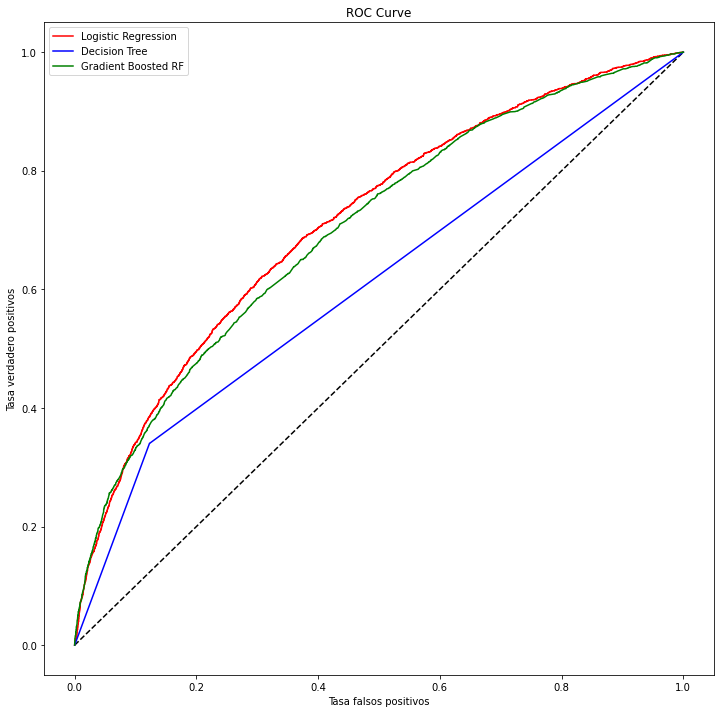

In [26]:
fpr1, tpr1, thresholds1 = roc_curve(y_test1, y_scores1[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test1, y_scores2[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test1, y_scores3[:,1])

fig = plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1], '--',color='black')
plt.plot(fpr1, tpr1, color='red', label='Logistic Regression')
plt.plot(fpr2, tpr2, color='blue', label='Decision Tree')
plt.plot(fpr3, tpr3, color='green', label='Gradient Boosted RF')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdadero positivos')
plt.legend()
plt.title('ROC Curve')
plt.show()

A continuación probamos correr el modelo con dos variables externas adicionales: El viento predominante y el nivel de caída de lluvia. Ambos vienen de las bases de datos (públicas) de http://www.meteochile.gob.cl/PortalDMC-web/index.xhtml. Específicamente datos tomados en la estación de Pudahuel, Santiago.

La justificación para usar estos valores sería que, por lo menos a nivel intuitivo es natural suponer que las condiciones climáticas pueden ser culpables de atrasar el itinerario de aeropuertos.

La variable de viento predominante es categórica y tipifica la dirección e intensidad. La variable de lluvia es continua e indica nivel de caída.  

El código que sigue es simplemente el reestablecimiento de nuestro dataframe con estas nuevas variables, y la corrida de los modelos de regresión logística similar a lo que hicimos anteriormente:$\\\\$

In [27]:
df_vientos = pd.read_csv('vientos.csv')
df_lluvias = pd.read_csv('lluvias.csv')
meses = df_vientos.columns
VIENTO = []
LLUVIA = []

for i in range(np.size(df2['MES'].values)):
    VIENTO.append(df_vientos[meses[df2['MES'].values[i]]][df2['DIA'].values[i]-1])
    LLUVIA.append(df_lluvias[meses[df2['MES'].values[i]]][df2['DIA'].values[i]-1])

LLUVIA = np.array(LLUVIA)
LLUVIA[LLUVIA=='s/p']=0
LLUVIA = np.array(LLUVIA,dtype=float)

df2['lluvia'] = LLUVIA
df2['viento'] = VIENTO

In [28]:
fields_fm.append('lluvia')
fields_fm.append('viento')
num_cols.append('lluvia')
cat_cols.append('viento')

X = df2[fields_fm]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y1, test_size=0.2, random_state=0)
print ('Tamaño muestra de entrenamiento: %d \n\nTamaño muestra de prueba: %d' % (X_train2.shape[0], X_test2.shape[0]))

Tamaño muestra de entrenamiento: 54564 

Tamaño muestra de prueba: 13642


In [29]:
ct11 = ColumnTransformer([
     ('s2', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)],remainder='passthrough')

p11 = Pipeline([
    ('ct', ct11),
    ('mod', model1)
])

p21 = Pipeline([
    ('ct', ct11),
    ('mod', model3)
])


In [30]:
p11.fit(X_train2, y_train2)
print("\n%0.3f Accuracy score para el modelo de regresión logística\n" % p11.score(X_test2, y_test2))

p21.fit(X_train2, y_train2)
print("\n%0.3f Accuracy score para el modelo de Gradient boosted trees\n" % p21.score(X_test2, y_test2))


0.822 Accuracy score para el modelo de regresión logística


0.820 Accuracy score para el modelo de Gradient boosted trees



In [31]:
#--------------------------------------------------------

predictions11 = p11.predict(X_test2)
y_scores11 = p11.predict_proba(X_test2)

print('\nMODELO REGRESIÓN LOGÍSTICA \n')
cm11 = confusion_matrix(y_test2, predictions11)
print ('Confusion Matrix:\n',cm11)
print("\nPrecision:",precision_score(y_test2, predictions11))
print("Recall:",recall_score(y_test2, predictions11))
print("F1:",f1_score(y_test2, predictions11))
auc11 = roc_auc_score(y_test2, y_scores11[:,1])
print('\nAUC: ' + str(auc11))

#--------------------------------------------------------

predictions21 = p21.predict(X_test2)
y_scores21 = p21.predict_proba(X_test2)

print('\n\n\nMODELO GRADIENT BOOSTED TREES \n')
cm21 = confusion_matrix(y_test2, predictions21)
print ('Confusion Matrix:\n',cm21)
print("\nPrecision:",precision_score(y_test2, predictions21))
print("Recall:",recall_score(y_test2, predictions21))
print("F1:",f1_score(y_test2, predictions21))
auc21 = roc_auc_score(y_test2, y_scores21[:,1])
print('\nAUC: ' + str(auc21))
print('\n')


MODELO REGRESIÓN LOGÍSTICA 

Confusion Matrix:
 [[10907   212]
 [ 2211   312]]

Precision: 0.5954198473282443
Recall: 0.12366230677764566
F1: 0.20479159829340335

AUC: 0.7158301375345739



MODELO GRADIENT BOOSTED TREES 

Confusion Matrix:
 [[11054    65]
 [ 2387   136]]

Precision: 0.6766169154228856
Recall: 0.053904082441537854
F1: 0.09985315712187959

AUC: 0.703296806710755




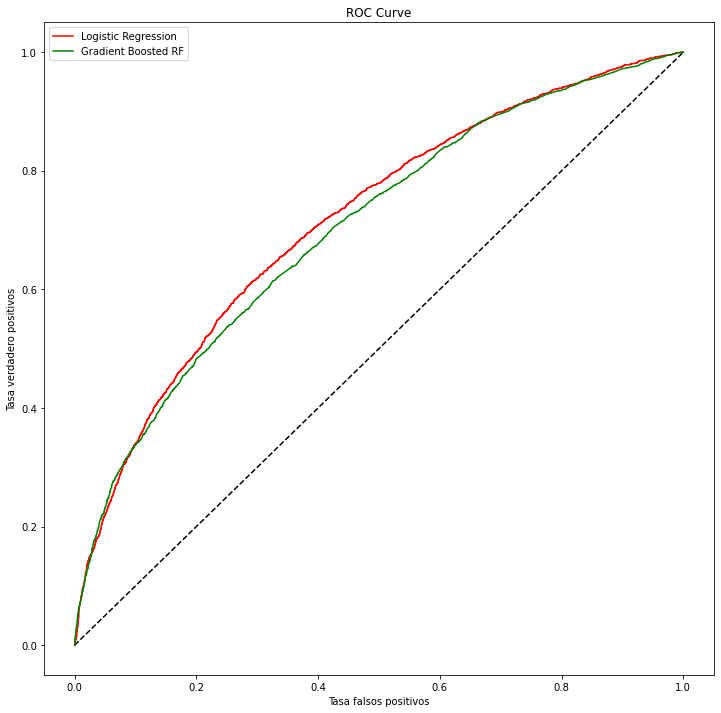

In [32]:
fpr11, tpr11, thresholds11 = roc_curve(y_test2, y_scores11[:,1])
fpr21, tpr21, thresholds21 = roc_curve(y_test2, y_scores21[:,1])

fig = plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1], '--',color='black')
plt.plot(fpr11, tpr11, color='red', label='Logistic Regression')
plt.plot(fpr21, tpr21, color='green', label='Gradient Boosted RF')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdadero positivos')
plt.legend()
plt.title('ROC Curve')
plt.show()

Notamos que hay una mejora en el poder de predicción en accuracy y de precision para el modelo de regresión logística, pero no es muy alta ($0.001$ puntos y $0.016$ puntos en cada score respectivamente). Fuera de esto las fluctuaciones generales en otras métricas son igualmente o más marginales. Esto nos dice que si es que hay una correlación entre las condiciones climáticas y la posibilidad de atraso de un vuelo, no es extremadamente relevante. 

Finalmente hacemos la inclusión de una variable adicional. Esta no es externa, sino que una generada a partir de los features que ya teníamos presentes. En este caso, a cada vuelo le asignamos la cantidad de otros vuelos con hora de salida programada en la media hora anterior/posterior. La idea es intentar cuantificar si la posibilidad de atraso está relacionada con la complejidad de la coordinación de la logística que viene de tener una cantidad más alta de vuelos programados en simultáneo.

De nuevo procedemos a incluir esta variable en nuestro dataframe y corremos los modelos de regresión logística: $\\\\$

In [33]:
booking = np.zeros(np.shape(df2['Fecha-I']))

for i in range(np.size(df2['Fecha-I'].values)):
    booking[i] = np.size(np.where( np.abs((df2['Fecha-I']-df2['Fecha-I'][i]).dt.total_seconds()/60) <= 30 )[0])


In [34]:
df2['booking'] = booking
df2['booking'].describe().T

fields_fm.append('booking')
num_cols.append('booking')
X = df2[fields_fm]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y1, test_size=0.2, random_state=0)
print ('Tamaño muestra de entrenamiento: %d \n\nTamaño muestra de prueba: %d' % (X_train3.shape[0], X_test3.shape[0]))

Tamaño muestra de entrenamiento: 54564 

Tamaño muestra de prueba: 13642


In [35]:
ct12 = ColumnTransformer([
     ('s2', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)],remainder='passthrough')

p12 = Pipeline([
    ('ct', ct12),
    ('mod', model1)
])

p22 = Pipeline([
    ('ct', ct12),
    ('mod', model3)
])

In [36]:
p12.fit(X_train3, y_train3)
print("\n%0.3f Accuracy para el modelo de regresión logística\n" % p12.score(X_test3, y_test3))

p22.fit(X_train3, y_train3)
print("\n%0.3f Accuracy para el modelo de gradient boosted trees\n" % p22.score(X_test3, y_test3))



0.822 Accuracy para el modelo de regresión logística


0.821 Accuracy para el modelo de gradient boosted trees



In [37]:
predictions12 = p12.predict(X_test3)
y_scores12 = p12.predict_proba(X_test3)

print('\nMODELO REGRESIÓN LOGÍSTICA \n')
cm12 = confusion_matrix(y_test3, predictions12)
print ('Confusion Matrix:\n',cm12)
print("\nPrecision:",precision_score(y_test3, predictions12))
print("Recall:",recall_score(y_test3, predictions12))
print("F1:",f1_score(y_test3, predictions12))
auc12 = roc_auc_score(y_test3, y_scores12[:,1])
print('\nAUC: ' + str(auc12))

#--------------------------------------------------------

predictions22 = p22.predict(X_test3)
y_scores22 = p22.predict_proba(X_test3)

print('\n\n\nMODELO GRADIENT BOOSTED TREES \n')
cm22 = confusion_matrix(y_test3, predictions22)
print ('Confusion Matrix:\n',cm22)
print("\nPrecision:",precision_score(y_test3, predictions22))
print("Recall:",recall_score(y_test3, predictions22))
print("F1:",f1_score(y_test3, predictions22))
auc22 = roc_auc_score(y_test3, y_scores22[:,1])
print('\nAUC: ' + str(auc22))
print('\n')


MODELO REGRESIÓN LOGÍSTICA 

Confusion Matrix:
 [[10895   224]
 [ 2210   313]]

Precision: 0.5828677839851024
Recall: 0.12405866032500991
F1: 0.2045751633986928

AUC: 0.7181747689223884



MODELO GRADIENT BOOSTED TREES 

Confusion Matrix:
 [[11057    62]
 [ 2382   141]]

Precision: 0.6945812807881774
Recall: 0.0558858501783591
F1: 0.10344827586206896

AUC: 0.7043221607545682




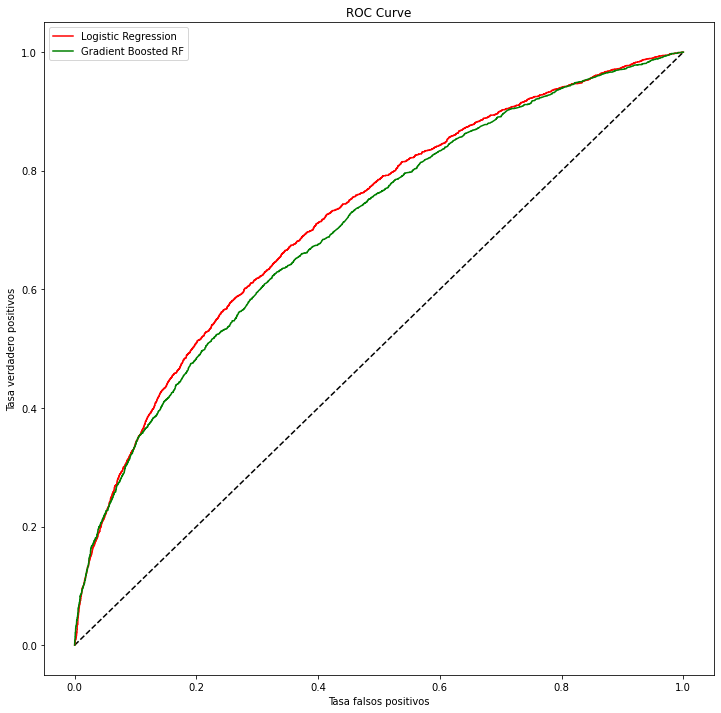

In [38]:
fpr12, tpr12, thresholds12 = roc_curve(y_test3, y_scores12[:,1])
fpr22, tpr22, thresholds22 = roc_curve(y_test3, y_scores22[:,1])

fig = plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1], '--',color='black')
plt.plot(fpr12, tpr12, color='red', label='Logistic Regression')
plt.plot(fpr22, tpr22, color='green', label='Gradient Boosted RF')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdadero positivos')
plt.legend()
plt.title('ROC Curve')
plt.show()

De nuevo notamos que esta variable no mejoró el rendimiento de nuestros modelos de manera evidente. Esto puede leerse de dos maneras: La cantidad de vuelos programados en simultáneo no pone carga sobre la capacidad que tienen las aerolíneas de que sus vuelos salgan a tiempo. O la opción de que algún otro de nuestros features ya explica este fenómeno (por ejemplo quizás la correlación entre el periodo dentro del día y la cantidad de vuelos programados en simultáneo podría ser muy alta).

# Evaluación y posibles mejoras

Corresponde ahora hacer un análisis del rendimiento de nuestros modelos. Primero resumamos los distintos coeficientes de determinación que hemos obtenido:

- $\textbf{Regresión logística}$:$\\\\$$\\\\$
    - Features iniciales: Accuracy = 0.821,$\,\,$ Precision = 0.579,$\,\,$ Recall = 0.119,$\,\,$ F1 = 0.198,$\,\,$ AUC = 0.713
    - Features iniciales con viento y lluvia: Accuracy = 0.822,$\,\,$ Precision = 0.595,$\,\,$ Recall = 0.124,$\,\,$ F1 = 0.204,$\,\,$ AUC = 0.716
    - Features iniciales con viento, lluvia y booking: Accuracy = 0.822,$\,\,$ Precision = 0.583,$\,\,$ Recall = 0.124,$\,\,$ F1 =  0.205,$\,\,$ AUC = 0.718
    $\\\\$

- $\textbf{Gradient boosted random forest}$:$\\\\$$\\\\$
    - Features iniciales: Accuracy = 0.820,$\,\,$ Precision = 0.676,$\,\,$ Recall = 0.055,$\,\,$ F1 = 0.101,$\,\,$ AUC = 0.701
    - Features iniciales con viento y lluvia: Accuracy = 0.820,$\,\,$ Precision = 0.677,$\,\,$ Recall = 0.054,$\,\,$ F1 = 0.1,$\,\,$ AUC = 0.703
    - Features iniciales con viento, lluvia y booking: Accuracy = 0.821,$\,\,$ Precision = 0.694,$\,\,$ Recall = 0.056,$\,\,$ F1 = 0.103,$\,\,$ AUC = 0.704
    $\\\\$

- $\textbf{Árbol de decisión}$:$\\\\$$\\\\$
    - Features iniciales: Accuracy = 0.777,$\,\,$ Precision = 0.386,$\,\,$ Recall = 0.34,$\,\,$ F1 = 0.362,$\,\,$ AUC = 0.609
    $\\\\$$\\\\$

    
Con esto vimos que el mejor rendimiento a priori debiese ser el de regresión logística, tanto el modelo base como cuando usamos nuestras variables extra. El único índice en que el modelo de GBRC muestra mejor rendimiento que la regresión logística, es en el índice de precisión, por lo que si pesamos la capacidad neta de captar falsos positivos, este modelo sería más recomendable.
$\\\\$$\\\\$
Ahora, tenemos nuestras distintas métricas y formas de ver el rendimiento de nuestro modelo en términos de valor predictivo. Surge la duda de como podríamos traducir estos resultados y métricas a un discriminante a la hora de tomar una decisión de negocios c/r a la decisión de si tomar un modelo u el otro, y ver el impacto real/monetario que tendrían dichas decisiones. Una primera aproximación, sería la de ver el impacto en términos de costos para la aerolínea, que tienen los falsos positivos v/s los falsos negativos.

De las matrices de confusión tenemos el conteo proporcional de falsos negativos y falsos positivos en términos del conjunto de prueba, y en función de que uno pueda definir el costo asociado a cada escenario, se puede hacer una comparación del costo asociado de un modelo v/s otro. En la práctica la definición de estos costos es compleja, pero intuitivamente el costo de un falso positivo debiese ser más alto por el costo de la logística asociada al evento inesperado (reagendamiento, pago de tiempo en aeropuerto, etc) y la baja en experiencia/apreciación por parte de los usuarios, versus el falso negativo que significa el costo de eficiencia de tener un avión parado innecesariamente.

Si definimos una función que, dado un costo por los malos-diagnósticos, nos dice las pérdidas asociadas a una matriz de confusión, podemos ver como se mueve la decisión de qué modelo utilizar:$$\\\\$$



In [99]:
def cost_of_predictions(CM,FN_cost,FP_cost,price_scaling=1):
    FP = CM[0,1]/(CM[0,0]+CM[0,1]+CM[0,1]+CM[1,1])
    FN = CM[1,0]/(CM[0,0]+CM[0,1]+CM[0,1]+CM[1,1])
    return (FP*FP_cost + FN*FN_cost)*price_scaling

comp1 = np.zeros((1000,1000))
comp2 = np.zeros((1000,1000))
comp3 = np.zeros((1000,1000))
C1 = 0
C2 = 0
C3 = 0

interv = np.linspace(0,1,1000)
for i in range(1000):
    fn = interv[i]
    for j in range(1000):
        fp = interv[j]
        if cost_of_predictions(cm1,i,j)>=cost_of_predictions(cm3,i,j):
            comp1[i,j] = 1
            C1 += 1
        if cost_of_predictions(cm11,i,j)>=cost_of_predictions(cm21,i,j):
            comp2[i,j] = 1
            C2 += 1
        if cost_of_predictions(cm12,i,j)>=cost_of_predictions(cm22,i,j):
            comp3[i,j] = 1
            C3 += 1
        

[]

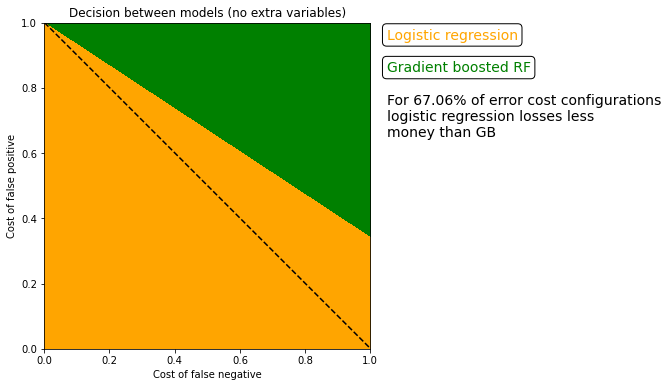

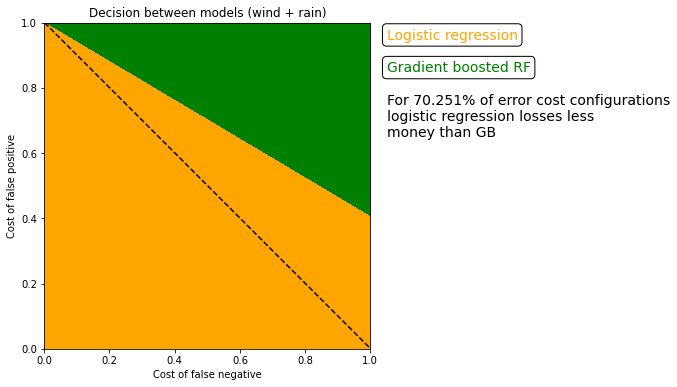

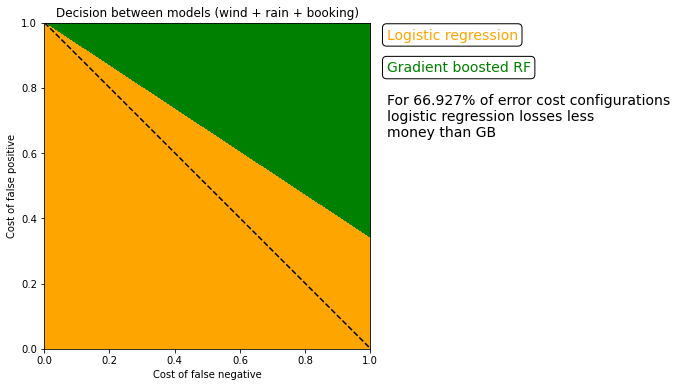

In [109]:
from matplotlib import colors
ex = (0,1,0,1)
props = dict(boxstyle='round', facecolor='white')#, alpha=0.5)
cmp = colors.ListedColormap(['orange', 'green'])

plt.figure(figsize=(6, 6))
plt.title('Decision between models (no extra variables)')
plt.xlabel('Cost of false negative')
plt.ylabel('Cost of false positive')
plt.imshow(comp1, cmap=cmp, extent=ex)
plt.text(1.05, 0.95, 'Logistic regression', fontsize=14,
        c='orange', bbox=props)
plt.text(1.05, 0.85, 'Gradient boosted RF', fontsize=14,
        c='green', bbox=props)
plt.text(1.05,0.65,f'For {np.round(((1-C1/1000000)*100),3)}% of error cost configurations\nlogistic regression losses less\nmoney than GB',
        fontsize=14)
plt.plot([0.001, 1], [1, 0.001], '--',color='black')
plt.plot()

plt.figure(figsize=(6, 6))
plt.title('Decision between models (wind + rain)')
plt.xlabel('Cost of false negative')
plt.ylabel('Cost of false positive')
plt.imshow(comp2, cmap=cmp, extent=ex)
plt.text(1.05, 0.95, 'Logistic regression', fontsize=14,
        c='orange', bbox=props)
plt.text(1.05, 0.85, 'Gradient boosted RF', fontsize=14,
        c='green', bbox=props)
plt.text(1.05,0.65,f'For {np.round(((1-C2/1000000)*100),3)}% of error cost configurations\nlogistic regression losses less\nmoney than GB',
        fontsize=14)
plt.plot([0.001, 1], [1, 0.001], '--',color='black')
plt.plot()

plt.figure(figsize=(6, 6))
plt.title('Decision between models (wind + rain + booking)')
plt.xlabel('Cost of false negative')
plt.ylabel('Cost of false positive')
plt.imshow(comp3, cmap=cmp, extent=ex)
plt.text(1.05, 0.95, 'Logistic regression', fontsize=14,
        c='orange', bbox=props)
plt.text(1.05, 0.85, 'Gradient boosted RF', fontsize=14,
        c='green', bbox=props)
plt.text(1.05,0.65,f'For {np.round(((1-C3/1000000)*100),3)}% of error cost configurations\nlogistic regression losses less\nmoney than GB',
        fontsize=14)
plt.plot([0.001, 1], [1, 0.001], '--',color='black')
plt.plot()



Los gráficos anteriores muestran que para la mayoría de las configuraciones de costos que uno le puede asociar a los falsos positivos/negativos, el uso del modelo de regresión logística sería mejor en términos monetarios, salvo en las configuraciones que presentan ambos casos de error con un alto costo. Este segundo punto era relativamente 'sospechable' viendo el precision score de ambos modelos.
$\\\\$$\\\\$

En este trabajo elegimos algoritmos clásicos de clasificación, y encontrar mejoras radicales a estos modelos en sí, es difícil. Un impulso sería mirar otros algoritmos de clasificación como SVM o procesos gaussianos (estos probablemente tendrían resultados similares a los algoritmos que probamos), o por ejemplo podríamos querer utilizar redes neuronales, pero la realidad es que para que se justifique el uso de estas, probablemente sería necesario tener un volumen de datos más alto. 
Si quisiéramos mejorar nuestro modelo de predicción lo más probable es que necesitamos variables adicionales nuevas. Debido a que los atrasos de avión en su mayoría hoy en día probablemente no se deban a errores de itinerario o a problemas de salida causadas por las condiciones climáticas en el aeropuerto de despegue, los problemas de atraso se deben causar principalmente a raíz de la mantención de los equipos.$\\\\$
Esto significaría que hay valores claves que podrían ayudarnos, por ejemplo:
- Cuán viejo es el avión de un vuelo dado. Esto nos dice cuan recurrentemente es necesario hacerle mantención, y cuál es la probabilidad de algún imprevisto antes del despegue

- Dado un vuelo, cuánto tiempo tiene en el aeropuerto el avión encargado. Esto nos va a decir cuan restrictivas son las condiciones para hacerle la mantención limpieza al vuelo, y mientras más margen de tiempo tengan, menos probable es un atraso en la próxima salida

Además vale notar como comentario final, que uno puede hablar acerca de las mejoras de un modelo dados ciertos datos y herramientas, pero la realidad es que si tener un baseline bien definido, esto es todo una comparación a escalas internas, y no tenemos una verdadera noción de cuánto aporte al negocio estos resultados dan.
